In [1]:
from __future__ import print_function

import os, sys
import numpy as np
import warnings

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [2]:
# Transform
BatchSize = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3801,))
])

In [3]:
# Data
# trainSet = datasets.MNIST(root='data', download=True, train=True, transform=transform)
# testSet  = datasets.MNIST(root='data', download=True, train=False, transform=transform)

# trainLoader = dset.DataLoader(trainSet, batch_size=BatchSize, shuffle=True)
# testLoader = dset.DataLoader(testSet, batch_size=BatchSize, shuffle=False)

In [4]:
class myMnistDataset(Dataset):
    
    csvPath = 'D:\\GitWork\\mnist\\processed\\'
    
    training_file = 'mnist_train.csv'
    test_file = 'mnist_test.csv'
    
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
    
    def __init__(self, train=True, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        data = np.loadtxt(os.path.join(self.csvPath, data_file), delimiter=',', dtype=np.float32)
        
        self.len = data.shape[0]
        imgs = torch.from_numpy(data[:, 1:])
        self.images = imgs.type(torch.uint8).view(self.len, 28, 28)
        
        lbls = torch.from_numpy(data[:, [0]])
        self.labels = lbls.view(self.len)

    def __getitem__(self, index):
        img, lbl = self.images[index], int(self.labels[index])
        
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')
        
        if self.transform is not None:
            img = self.transform(img)
        
        if self.target_transform is not None:
            lbl = self.target_transform(lbl)
            
        return img, lbl

    def __len__(self):
        return self.len
    
    @property
    def train_labels(self):
        return self.labels

    @property
    def test_labels(self):
        return self.labels

    @property
    def train_data(self):
        return self.images

    @property
    def test_data(self):
        return self.images


In [5]:
# Create datasets
trainSet = myMnistDataset(train=True, transform=transform)
testSet = myMnistDataset(train=False, transform=transform)

trainLoader = DataLoader(dataset=trainSet, batch_size=BatchSize, shuffle=True)
testLoader = DataLoader(dataset=testSet, batch_size=BatchSize, shuffle=False)   

print(trainSet.train_data.size())
print(trainSet.train_labels.size())

print(type(trainSet.train_data[0]))
print(type(trainSet.train_labels[0]))

print(trainSet.train_data[0])
print(trainSet.train_labels[0])

torch.Size([60000, 28, 28])
torch.Size([60000])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175

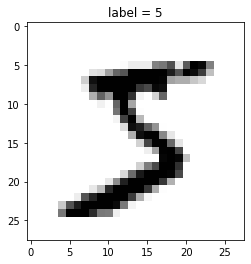

In [6]:
import matplotlib.pyplot as plt

plt.imshow(trainSet.train_data[0].numpy(), cmap='binary')
plt.title('label = %i' % trainSet.train_labels[0])
plt.show()

In [7]:
# GPU
use_gpu = torch.cuda.is_available()
device = 'cuda:0' if use_gpu else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [8]:
# Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=784, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)


net = Net().to(device)
print(net)

Net(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax()
  )
)


In [9]:
# Parameters
epochs = 3
lr = 0.002
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)

# Train
for epoch in range(epochs):
    running_loss = 0.0

    for i, data in enumerate(trainLoader):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.view(inputs.shape[0], -1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Foward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % BatchSize == 0 or i+1 == len(trainLoader):
            print('[%d/%d, %d/%d] loss: %.3f' % (epoch+1, epochs, i+1, len(trainLoader), running_loss/2000))

print('Training Finished.')

[1/3, 100/600] loss: 0.107
[1/3, 200/600] loss: 0.173
[1/3, 300/600] loss: 0.207
[1/3, 400/600] loss: 0.232
[1/3, 500/600] loss: 0.253
[1/3, 600/600] loss: 0.272
[2/3, 100/600] loss: 0.018
[2/3, 200/600] loss: 0.034
[2/3, 300/600] loss: 0.050
[2/3, 400/600] loss: 0.065
[2/3, 500/600] loss: 0.080
[2/3, 600/600] loss: 0.095
[3/3, 100/600] loss: 0.013
[3/3, 200/600] loss: 0.027
[3/3, 300/600] loss: 0.040
[3/3, 400/600] loss: 0.053
[3/3, 500/600] loss: 0.066
[3/3, 600/600] loss: 0.078
Training Finished.


In [10]:
# Test
correct = 0
total = 0

with torch.no_grad():
    for data in testLoader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(inputs.shape[0], -1)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct / total))

class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]

with torch.no_grad():
    for data in testLoader:
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.view(inputs.shape[0], -1)

        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            # print(class_correct)
            # print(class_total)

for i in range(10):
    print('Accuracy of %d: %3f' % (i, (class_correct[i]/class_total[i])))

Accuracy of the network on the 10000 test images: 93 %
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 1, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 2]
[1, 2, 1, 0, 2, 1, 0, 1, 0, 2]
[1, 2, 1, 0, 2, 0, 1, 1, 0, 2]
[1, 2, 1, 0, 2, 1, 1, 1, 0, 2]
[2, 2, 1, 0, 2, 0, 1, 1, 0, 2]
[2, 2, 1, 0, 2, 1, 1, 1, 0, 2]
[2, 2, 1, 0, 2, 1, 1, 1, 0, 2]
[2, 2, 1, 0, 2, 2, 1, 1, 0, 2]
[2, 2, 1, 0, 3, 1, 1, 1, 0, 2]
[2, 2, 1, 0, 3, 2, 1, 1, 0, 2]
[2, 2, 1, 0, 3, 1, 1, 1, 0, 3]
[2, 2, 1, 0, 3, 2, 1, 1, 0, 3]
[2, 2, 1, 0, 3,

[13, 20, 14, 13, 16, 7, 12, 12, 9, 17]
[13, 20, 14, 15, 18, 10, 12, 13, 13, 18]
[13, 20, 14, 13, 16, 8, 12, 12, 9, 17]
[13, 20, 14, 15, 18, 11, 12, 13, 13, 18]
[13, 20, 15, 13, 16, 8, 12, 12, 9, 17]
[13, 20, 15, 15, 18, 11, 12, 13, 13, 18]
[14, 20, 15, 13, 16, 8, 12, 12, 9, 17]
[14, 20, 15, 15, 18, 11, 12, 13, 13, 18]
[14, 20, 15, 13, 16, 8, 12, 12, 9, 17]
[14, 20, 16, 15, 18, 11, 12, 13, 13, 18]
[14, 20, 15, 13, 16, 8, 12, 12, 9, 17]
[14, 20, 16, 15, 18, 11, 12, 14, 13, 18]
[14, 20, 15, 13, 16, 8, 12, 12, 9, 18]
[14, 20, 16, 15, 18, 11, 12, 14, 13, 19]
[14, 20, 15, 13, 16, 8, 12, 12, 10, 18]
[14, 20, 16, 15, 18, 11, 12, 14, 14, 19]
[14, 20, 15, 14, 16, 8, 12, 12, 10, 18]
[14, 20, 16, 16, 18, 11, 12, 14, 14, 19]
[15, 20, 15, 14, 16, 8, 12, 12, 10, 18]
[15, 20, 16, 16, 18, 11, 12, 14, 14, 19]
[15, 20, 15, 14, 16, 8, 12, 13, 10, 18]
[15, 20, 16, 16, 18, 11, 12, 15, 14, 19]
[15, 20, 16, 14, 16, 8, 12, 13, 10, 18]
[15, 20, 17, 16, 18, 11, 12, 15, 14, 19]
[15, 20, 16, 14, 16, 8, 12, 14, 10,

[26, 28, 24, 30, 31, 17, 21, 28, 19, 24]
[26, 28, 26, 34, 33, 20, 22, 31, 23, 28]
[26, 28, 24, 30, 32, 17, 21, 28, 19, 24]
[26, 28, 26, 34, 34, 20, 22, 31, 23, 28]
[26, 28, 24, 30, 32, 17, 22, 28, 19, 24]
[26, 28, 26, 34, 34, 20, 23, 31, 23, 28]
[27, 28, 24, 30, 32, 17, 22, 28, 19, 24]
[27, 28, 26, 34, 34, 20, 23, 31, 23, 28]
[27, 29, 24, 30, 32, 17, 22, 28, 19, 24]
[27, 29, 26, 34, 34, 20, 23, 31, 23, 28]
[27, 30, 24, 30, 32, 17, 22, 28, 19, 24]
[27, 30, 26, 34, 34, 20, 23, 31, 23, 28]
[27, 31, 24, 30, 32, 17, 22, 28, 19, 24]
[27, 31, 26, 34, 34, 20, 23, 31, 23, 28]
[28, 31, 24, 30, 32, 17, 22, 28, 19, 24]
[28, 31, 26, 34, 34, 20, 23, 31, 23, 28]
[28, 31, 24, 30, 33, 17, 22, 28, 19, 24]
[28, 31, 26, 34, 35, 20, 23, 31, 23, 28]
[28, 31, 24, 30, 34, 17, 22, 28, 19, 24]
[28, 31, 26, 34, 36, 20, 23, 31, 23, 28]
[28, 31, 24, 30, 34, 17, 22, 28, 20, 24]
[28, 31, 26, 34, 36, 20, 23, 31, 24, 28]
[28, 31, 24, 30, 34, 17, 23, 28, 20, 24]
[28, 31, 26, 34, 36, 20, 24, 31, 24, 28]
[28, 31, 25, 30,

[37, 42, 38, 39, 42, 25, 36, 42, 33, 34]
[37, 43, 40, 44, 46, 32, 38, 47, 39, 41]
[37, 42, 38, 39, 42, 25, 36, 43, 33, 34]
[37, 43, 40, 44, 46, 32, 38, 48, 39, 41]
[37, 42, 38, 39, 42, 25, 37, 43, 33, 34]
[37, 43, 40, 44, 46, 32, 39, 48, 39, 41]
[37, 42, 38, 39, 42, 25, 37, 43, 33, 35]
[37, 43, 40, 44, 46, 32, 39, 48, 39, 42]
[37, 42, 39, 39, 42, 25, 37, 43, 33, 35]
[37, 43, 41, 44, 46, 32, 39, 48, 39, 42]
[37, 42, 39, 39, 42, 25, 37, 43, 33, 36]
[37, 43, 41, 44, 46, 32, 39, 48, 39, 43]
[37, 42, 39, 39, 42, 25, 37, 44, 33, 36]
[37, 43, 41, 44, 46, 32, 39, 49, 39, 43]
[37, 42, 40, 39, 42, 25, 37, 44, 33, 36]
[37, 43, 42, 44, 46, 32, 39, 49, 39, 43]
[37, 43, 40, 39, 42, 25, 37, 44, 33, 36]
[37, 44, 42, 44, 46, 32, 39, 49, 39, 43]
[37, 44, 40, 39, 42, 25, 37, 44, 33, 36]
[37, 45, 42, 44, 46, 32, 39, 49, 39, 43]
[37, 44, 40, 40, 42, 25, 37, 44, 33, 36]
[37, 45, 42, 45, 46, 32, 39, 49, 39, 43]
[37, 44, 40, 40, 42, 25, 37, 45, 33, 36]
[37, 45, 42, 45, 46, 32, 39, 50, 39, 43]
[37, 44, 40, 40,

[49, 59, 54, 52, 50, 36, 46, 51, 44, 51]
[49, 61, 57, 59, 55, 44, 48, 56, 52, 60]
[49, 59, 54, 52, 50, 36, 47, 51, 44, 51]
[49, 61, 57, 59, 55, 44, 49, 56, 52, 60]
[49, 59, 54, 52, 50, 36, 47, 52, 44, 51]
[49, 61, 57, 59, 55, 44, 49, 57, 52, 60]
[49, 59, 54, 52, 50, 36, 47, 52, 45, 51]
[49, 61, 57, 59, 55, 44, 49, 57, 53, 60]
[49, 59, 54, 52, 50, 36, 47, 52, 45, 52]
[49, 61, 57, 59, 55, 44, 49, 57, 53, 61]
[50, 59, 54, 52, 50, 36, 47, 52, 45, 52]
[50, 61, 57, 59, 55, 44, 49, 57, 53, 61]
[50, 60, 54, 52, 50, 36, 47, 52, 45, 52]
[50, 62, 57, 59, 55, 44, 49, 57, 53, 61]
[50, 60, 55, 52, 50, 36, 47, 52, 45, 52]
[50, 62, 58, 59, 55, 44, 49, 57, 53, 61]
[50, 60, 55, 53, 50, 36, 47, 52, 45, 52]
[50, 62, 58, 60, 55, 44, 49, 57, 53, 61]
[50, 60, 55, 53, 51, 36, 47, 52, 45, 52]
[50, 62, 58, 60, 56, 44, 49, 57, 53, 61]
[50, 60, 55, 53, 52, 36, 47, 52, 45, 52]
[50, 62, 58, 60, 57, 44, 49, 57, 53, 61]
[50, 60, 55, 53, 52, 36, 48, 52, 45, 52]
[50, 62, 58, 60, 57, 44, 50, 57, 53, 61]
[50, 60, 56, 53,

[60, 78, 65, 69, 62, 45, 64, 67, 55, 70]
[60, 80, 69, 76, 67, 54, 66, 73, 66, 80]
[60, 79, 65, 69, 62, 45, 64, 67, 55, 70]
[60, 81, 69, 76, 67, 54, 66, 73, 66, 80]
[60, 80, 65, 69, 62, 45, 64, 67, 55, 70]
[60, 82, 69, 76, 67, 54, 66, 73, 66, 80]
[60, 80, 65, 69, 62, 45, 64, 67, 55, 71]
[60, 82, 69, 76, 67, 54, 66, 73, 66, 81]
[60, 80, 65, 69, 62, 45, 64, 67, 56, 71]
[60, 82, 69, 76, 67, 54, 66, 73, 67, 81]
[60, 80, 65, 69, 62, 45, 64, 67, 56, 72]
[60, 82, 69, 76, 67, 54, 66, 73, 67, 82]
[60, 80, 66, 69, 62, 45, 64, 67, 56, 72]
[60, 82, 70, 76, 67, 54, 66, 73, 67, 82]
[60, 80, 66, 70, 62, 45, 64, 67, 56, 72]
[60, 82, 70, 77, 67, 54, 66, 73, 67, 82]
[60, 80, 66, 70, 62, 46, 64, 67, 56, 72]
[60, 82, 70, 77, 67, 55, 66, 73, 67, 82]
[60, 80, 66, 70, 62, 47, 64, 67, 56, 72]
[60, 82, 70, 77, 67, 56, 66, 73, 67, 82]
[60, 81, 66, 70, 62, 47, 64, 67, 56, 72]
[60, 83, 70, 77, 67, 56, 66, 73, 67, 82]
[60, 81, 67, 70, 62, 47, 64, 67, 56, 72]
[60, 83, 71, 77, 67, 56, 66, 73, 67, 82]
[60, 81, 68, 70,

[71, 96, 84, 88, 78, 64, 79, 87, 81, 93]
[71, 94, 80, 81, 73, 55, 77, 81, 68, 83]
[71, 96, 84, 89, 78, 64, 79, 87, 81, 93]
[71, 94, 80, 81, 73, 55, 77, 82, 68, 83]
[71, 96, 84, 89, 78, 64, 79, 88, 81, 93]
[71, 94, 80, 81, 73, 55, 77, 83, 68, 83]
[71, 96, 84, 89, 78, 64, 79, 89, 81, 93]
[71, 94, 80, 81, 74, 55, 77, 83, 68, 83]
[71, 96, 84, 89, 79, 64, 79, 89, 81, 93]
[71, 94, 80, 81, 75, 55, 77, 83, 68, 83]
[71, 96, 84, 89, 80, 64, 79, 89, 81, 93]
[71, 94, 80, 82, 75, 55, 77, 83, 68, 83]
[71, 96, 84, 90, 80, 64, 79, 89, 81, 93]
[71, 94, 80, 82, 75, 55, 77, 83, 68, 84]
[71, 96, 84, 90, 80, 64, 79, 89, 81, 94]
[71, 94, 81, 82, 75, 55, 77, 83, 68, 84]
[71, 96, 85, 90, 80, 64, 79, 89, 81, 94]
[71, 94, 81, 82, 75, 55, 77, 83, 69, 84]
[71, 96, 85, 90, 80, 64, 79, 89, 82, 94]
[71, 94, 81, 82, 75, 55, 77, 83, 70, 84]
[71, 96, 85, 90, 80, 64, 79, 89, 83, 94]
[71, 94, 81, 82, 75, 55, 77, 83, 71, 84]
[71, 96, 85, 90, 80, 64, 79, 89, 84, 94]
[71, 94, 81, 82, 75, 55, 77, 84, 71, 84]
[71, 96, 85, 90,

[78, 111, 96, 99, 88, 65, 85, 99, 79, 97]
[78, 113, 100, 108, 94, 74, 87, 106, 94, 107]
[79, 111, 96, 99, 88, 65, 85, 99, 79, 97]
[79, 113, 100, 108, 94, 74, 87, 106, 94, 107]
[79, 112, 96, 99, 88, 65, 85, 99, 79, 97]
[79, 114, 100, 108, 94, 74, 87, 106, 94, 107]
[79, 112, 97, 99, 88, 65, 85, 99, 79, 97]
[79, 114, 101, 108, 94, 74, 87, 106, 94, 107]
[79, 112, 97, 100, 88, 65, 85, 99, 79, 97]
[79, 114, 101, 109, 94, 74, 87, 106, 94, 107]
[79, 112, 97, 100, 89, 65, 85, 99, 79, 97]
[79, 114, 101, 109, 95, 74, 87, 106, 94, 107]
[79, 112, 97, 100, 89, 66, 85, 99, 79, 97]
[79, 114, 101, 109, 95, 75, 87, 106, 94, 107]
[79, 112, 97, 100, 89, 66, 86, 99, 79, 97]
[79, 114, 101, 109, 95, 75, 88, 106, 94, 107]
[79, 112, 97, 100, 89, 66, 86, 100, 79, 97]
[79, 114, 101, 109, 95, 75, 88, 107, 94, 107]
[79, 112, 97, 100, 89, 66, 86, 100, 80, 97]
[79, 114, 101, 109, 95, 75, 88, 107, 95, 107]
[79, 112, 97, 100, 89, 66, 86, 100, 80, 97]
[79, 114, 102, 109, 95, 75, 88, 107, 95, 107]
[79, 112, 97, 100, 89,